In [1]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [2]:
import duckdb
import pandas as pd
import geopandas as gpd
from shapely import wkb
import matplotlib.pyplot as plt
import scipy.stats as st
import contextily as cx
import numpy as np
import xyzservices.providers as xyz

In [3]:
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

Tip: You may define configurations in /Users/saadiqmohiuddin/Documents/gtfs-realtime-etl/notebooks/pyproject.toml or /Users/saadiqmohiuddin/.jupysql/config.

Did not find user configurations in /Users/saadiqmohiuddin/Documents/gtfs-realtime-etl/notebooks/pyproject.toml.

In [4]:
%%sql
INSTALL httpfs;
LOAD httpfs;
INSTALL spatial;
LOAD spatial;

,Success


In [5]:
agency = 'ttc'
timezones = {
    "ttc": 'America/Toronto',
    "octranspo": 'America/Toronto',
    "calgary": 'America/Edmonton',
    "edmonton": 'America/Edmonton',
    "stm": 'America/Toronto'
}

In [6]:
%sql SET GLOBAL timezone='{{timezones.get(agency)}}';

,Success


In [7]:
#Download and unzip merged ttc GTFS data: https://open.toronto.ca/dataset/merged-gtfs-ttc-routes-and-schedules/

In [8]:
%%sql
CREATE TABLE IF NOT EXISTS trips AS
    SELECT * FROM read_csv('data/{{agency}}/trips.txt');

CREATE TABLE IF NOT EXISTS stops AS
SELECT
    *,
    ST_Point(stop_lon, stop_lat) AS stop_loc
FROM read_csv('data/{{agency}}/stops.txt', types={'stop_id': 'VARCHAR'});

CREATE TABLE IF NOT EXISTS routes AS
    SELECT * FROM read_csv('data/{{agency}}/routes.txt');

CREATE TABLE IF NOT EXISTS shapes AS
    SELECT * FROM read_csv('data/{{agency}}/shapes.txt');

CREATE TABLE IF NOT EXISTS stop_times AS
    SELECT * FROM read_csv('data/{{agency}}/stop_times.txt', types={'stop_id': 'VARCHAR'});

,Count
0,4316828


In [9]:
#Create view of vehicle positions

In [10]:
%%sql 
CREATE VIEW IF NOT EXISTS locations AS
SELECT * FROM read_parquet('s3://gtfs-rt-etl-data/{{agency}}/positions/year=*/month=*/day=*/*.parquet', hive_partitioning = true);
FROM (DESCRIBE locations);


,column_name,column_type,null,key,default,extra
0,trip_id,VARCHAR,YES,None,None,None
1,route_id,VARCHAR,YES,None,None,None
2,direction_id,VARCHAR,YES,None,None,None
3,vehicle_id,VARCHAR,YES,None,None,None
4,bearing,DOUBLE,YES,None,None,None
5,speed,DOUBLE,YES,None,None,None
6,timestamp,TIMESTAMP WITH TIME ZONE,YES,None,None,None
7,geohash,VARCHAR,YES,None,None,None
8,geometry,GEOMETRY,YES,None,None,None
9,bbox,"STRUCT(xmin DOUBLE, ymin DOUBLE, xmax DOUBLE, ...",YES,None,None,None


In [11]:
%sql select count(*) from locations;

,count_star()
0,21312146


In [12]:
%%time
%%sql df << SELECT 
    stop_id,
    COUNT(diff) AS count,
    AVG(diff) AS avg_diff,
    STDDEV(diff) AS stddev_diff,
    ST_AsHEXWKB(stop_loc) as geometry
FROM (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY trip_id, stop_id, arrival_time, stop_sequence
            ORDER BY arrival_time ASC, ABS(diff) ASC
        ) AS rn
    FROM (
        SELECT 
            X.trip_id,
            T.route_short_name,
            S.stop_sequence,
            S.arrival_time,
            DATEDIFF(
                'seconds', 
                S.arrival_time::TIME,
                strftime(Y.timestamp, '%H:%M:%S')::TIME
            ) AS diff,
            S.stop_id,
            V.stop_loc
        FROM routes AS T
        JOIN trips AS X ON T.route_id = X.route_id
        JOIN stop_times AS S ON X.trip_id = S.trip_id
        JOIN stops AS V ON S.stop_id = V.stop_id
        JOIN locations AS Y
            ON X.trip_id = Y.trip_id
           AND ST_DWithin(Y.geometry, V.stop_loc, 0.0002)
        WHERE NOT regexp_matches(S.arrival_time,'^(2[4-9]|3[0-5]):', 'c') and (T.route_type = 700 OR T.route_type = 3)
    ) AS matched
    WHERE diff BETWEEN -600 AND 600 
) AS ranked
WHERE rn = 1
GROUP BY stop_id, stop_loc;

CPU times: user 1min 12s, sys: 1.25 s, total: 1min 13s
Wall time: 18.2 s


In [13]:
df['geometry'] = df['geometry'].apply(wkb.loads)

# Create the GeoDataFrame, specifying the geometry column
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)
gdf.head()


,stop_id,count,avg_diff,stddev_diff,geometry
0,10280,132,-7.242424,218.721899,POINT (-8852510.183 5415230.796)
1,9517,171,-10.374269,144.203574,POINT (-8836005.732 5415461.511)
2,2392,148,-1.804054,111.445155,POINT (-8824104.232 5439964.291)
3,5993,142,31.866197,103.683932,POINT (-8825152.416 5423705.319)
4,1021,308,-2.590909,237.985495,POINT (-8832555.719 5420281.529)


In [14]:
# Calculate Reliability

In [15]:
gdf = gdf.dropna()
gdf["z_min"] = (-60-gdf["avg_diff"])/gdf["stddev_diff"]
gdf["z_max"] = (300-df["avg_diff"])/gdf["stddev_diff"]
gdf["reliability"]= st.norm.cdf(gdf["z_max"])-st.norm.cdf(gdf["z_min"])
gdf.head()

,stop_id,count,avg_diff,stddev_diff,geometry,z_min,z_max,reliability
0,10280,132,-7.242424,218.721899,POINT (-8852510.183 5415230.796),-0.241208,1.404717,0.515251
1,9517,171,-10.374269,144.203574,POINT (-8836005.732 5415461.511),-0.344137,2.152334,0.618943
2,2392,148,-1.804054,111.445155,POINT (-8824104.232 5439964.291),-0.522194,2.708095,0.695849
3,5993,142,31.866197,103.683932,POINT (-8825152.416 5423705.319),-0.886022,2.586069,0.807343
4,1021,308,-2.590909,237.985495,POINT (-8832555.719 5420281.529),-0.241229,1.271468,0.493530


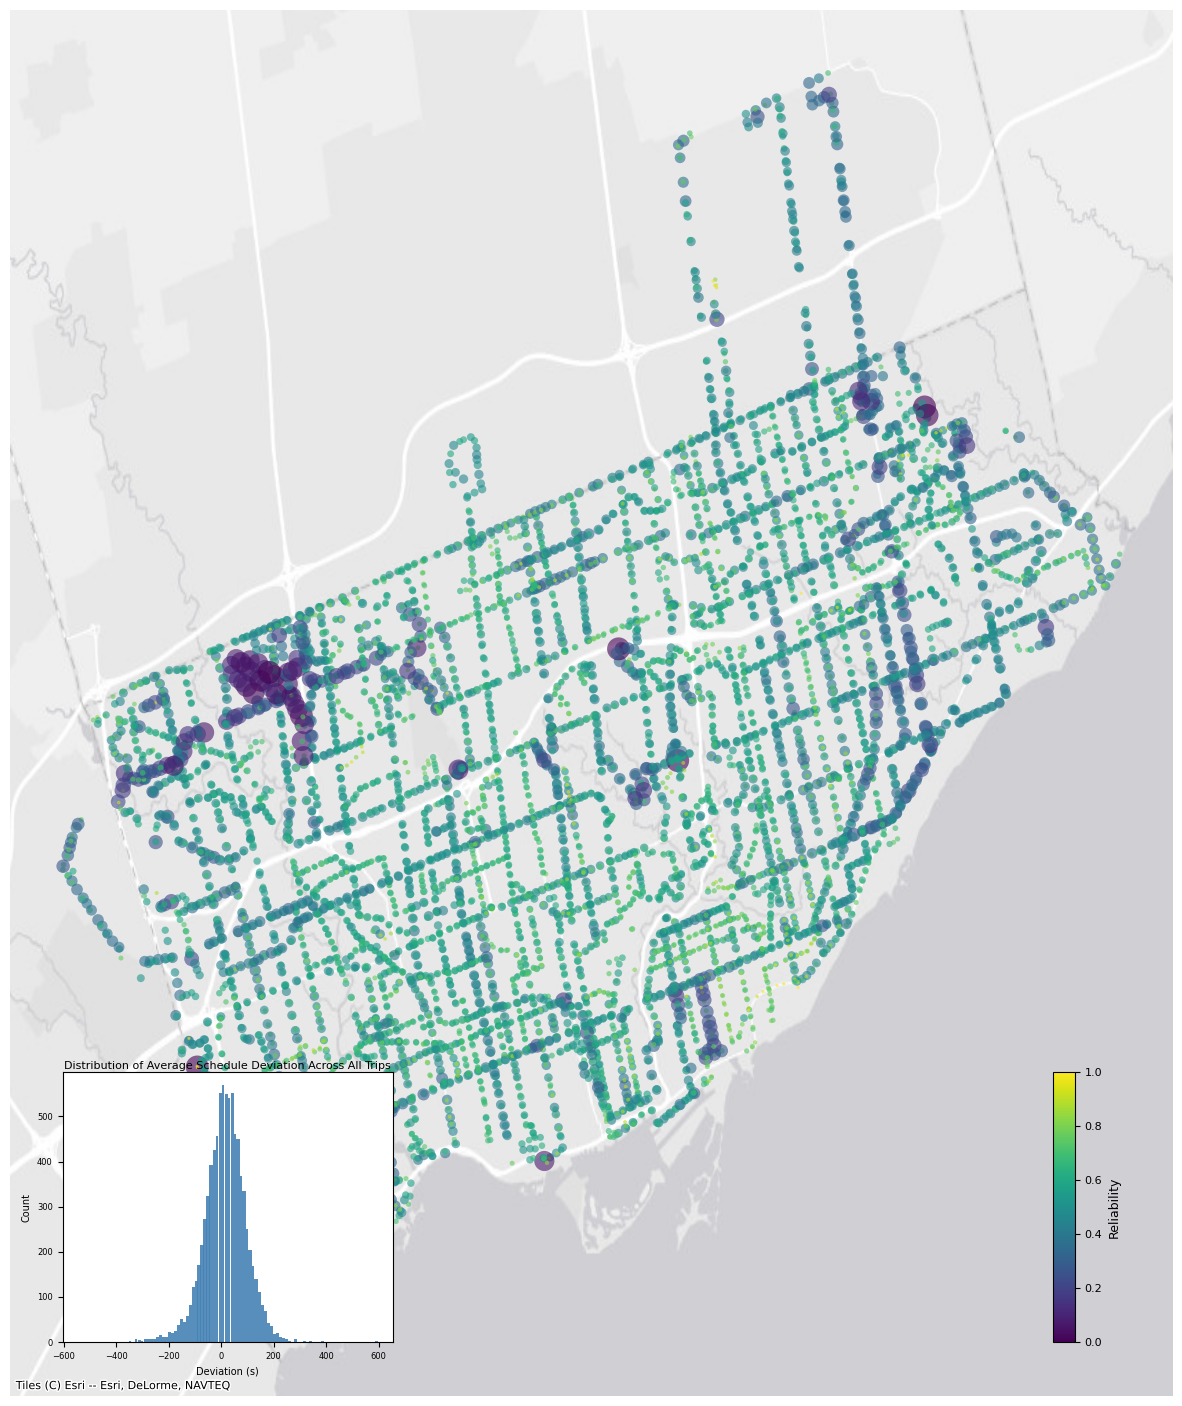

In [16]:
fig, ax = plt.subplots(figsize=(15, 18))

a, b = 5, 4
sizes = a * np.exp(b * (1 - gdf["reliability"]))

sc = ax.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["reliability"],
    s=sizes,
    cmap="viridis",
    alpha=0.6,
    edgecolors="none" 
)
cx.add_basemap(ax, source=xyz.Esri.WorldGrayCanvas)

sm = plt.cm.ScalarMappable(
    cmap="viridis", 
    norm=plt.Normalize(vmin=gdf["reliability"].min(), vmax=gdf["reliability"].max())
)
cax = fig.add_axes([0.82, 0.14, 0.015, 0.15]) 

# Draw the colorbar in that axes
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Reliability", fontsize=9)
ax.set_axis_off()

# Add histogram
inset_ax = fig.add_axes([0.16, 0.14, 0.22, 0.15], facecolor="white")
inset_ax.hist(df["avg_diff"], bins=100, color="steelblue", alpha=0.9)
inset_ax.set_title("Distribution of Average Schedule Deviation Across All Trips", fontsize=8, pad=2)
inset_ax.set_xlabel("Deviation (s)", fontsize=7)
inset_ax.set_ylabel("Count", fontsize=7)
inset_ax.tick_params(axis='both', labelsize=6)

# Save & show
plt.savefig(f"reliability_{agency}.png", bbox_inches="tight", dpi=300)
plt.show()